In [46]:
# Load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

# Read training dataset
df = pd.read_csv("../Dataset/train.csv")

# Remove irrelevant columns from the dataset
df = df.drop(["DATE", "VIDEO_NAME"], axis = 1)

# Load training features and responses
Xtrain = df["CONTENT"]
Ytrain = df["CLASS"]

# Split the training dataset with 80-20 split
Xtrain_train, Xtrain_test, Ytrain_train, Ytrain_test = \
train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 3)

# Change the min_df from 1 to 2, i.e, if a word appears in less than 2 sentences, drop it. 
feature_extraction = TfidfVectorizer(min_df = 2, stop_words = 'english', lowercase = True)
Xtrain_train_features = feature_extraction.fit_transform(Xtrain_train)
Xtrain_test_features = feature_extraction.transform(Xtrain_test)

#let's make sure the labels for Y are in int form e.g 0, 1 and not any other like "0", "1"
Ytrain_train = Ytrain_train.astype('int')
Ytrain_test = Ytrain_test.astype('int')

# Read the test data set and extract comments column
df_test = pd.read_csv("../Dataset/test.csv")
comments_test = df_test["CONTENT"]

# Use TF-IDF vectorizer to vectorize test data and extract features
Xtest_test_features = feature_extraction.transform(comments_test)

Assess the dataset for linearity, non-linearity, clusters, outliers, etc. 

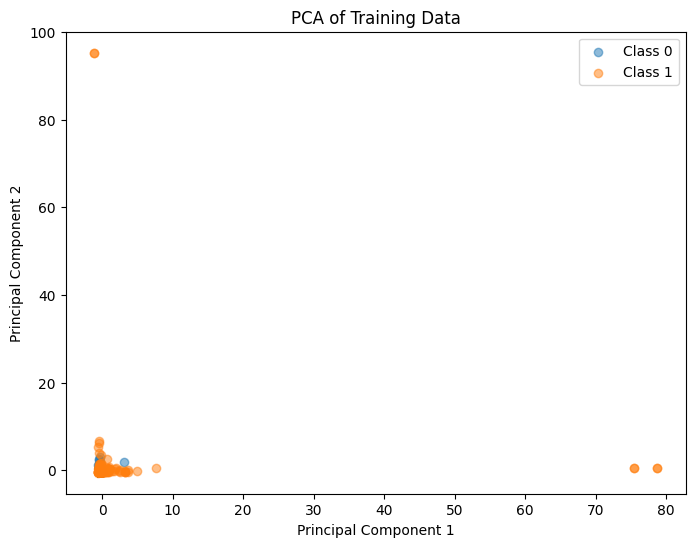

In [6]:

# Assess the dataset for linearity, non-linearity, clusters, outliers, etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.toarray())  # Convert to dense for PCA

# Since we have binary labels in Ytrain_train
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[Ytrain_train == 0, 0], X_pca[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_pca[Ytrain_train == 1, 0], X_pca[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.legend()
plt.show()

PCA plot above shows how the data is generated along the first two principal components. These capture the direction of maximum variance in the data. Since we see one cluster near the origin we see a common pattern between spam and not  spam. But looking closely, there is a significant overlap between the two classes in that cluster. It can be very challenging for a linear model like Logistic Regression to classify these points in this scenario. 

There are also points further away from the cluster, these could be outliers or potentially unique samples. 

Since PCA performs is a linear transformation from high dimension to lower dimension, it may not capture complex, non-liinear relationships. Since we see data in the cluster being not well separated, we will consider t-SNE and UMAP for capturing the non-linear patterns.

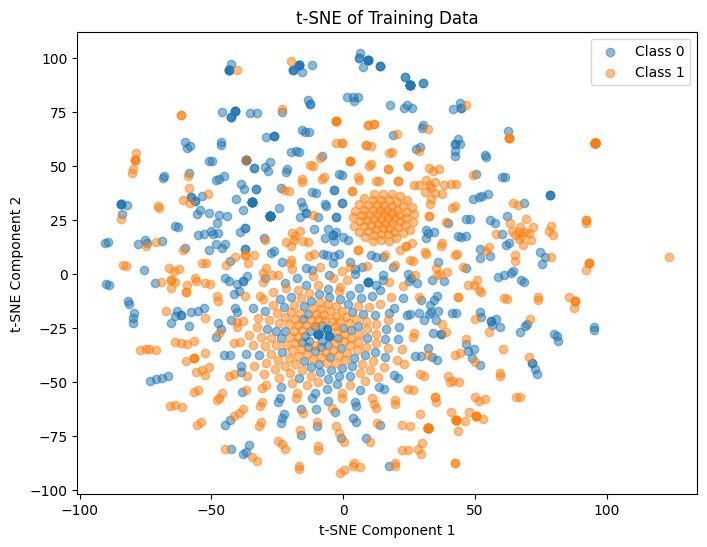

In [8]:
# t_SNE to plot features 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled.toarray())  # Convert to dense if necessary

# Plotting t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[Ytrain_train == 0, 0], X_tsne[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_tsne[Ytrain_train == 1, 0], X_tsne[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Training Data')
plt.legend()
plt.show()


### t-distributed Stochastic Neighbour Embedding

The above plot shows how the data is distributed in the first two significant components of t-SNE. We see one cluster where the data is very well separated. This might indicate why we see a good prediction model from Logistic Regression model. However, if you look closely in the second cluster, you can see the data is between two classes are not very well separated. t-SNE is good at preserving local structures, so points that are close together in this plot are likely similar in the high-dimensional space. 

There are also many points that are scattered further away from these two main clusters. These could either be outliers or unique samples that must be treated with care. 



Next, we can also take a look UMAP, which preserves both local and global structures of the data better than t-SNE.

/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


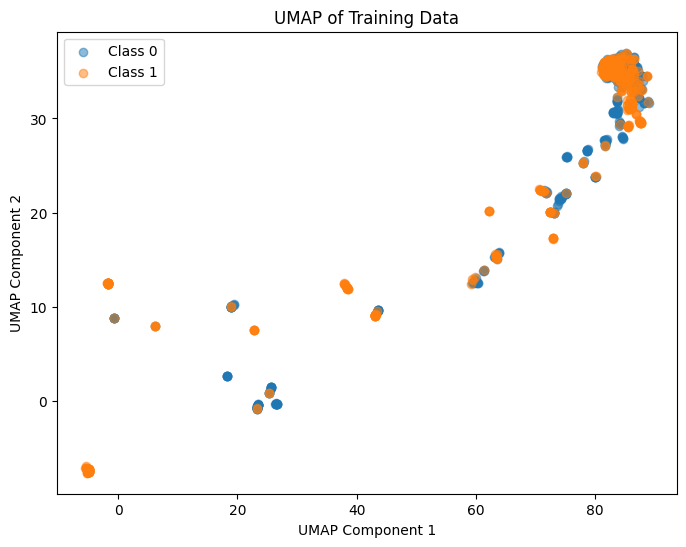

In [9]:
# UMAP for visualizing distribution of the data
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# Standardize the features without centering
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(Xtrain_train_features)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled.toarray())  # Convert to dense if necessary

# Plotting UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[Ytrain_train == 0, 0], X_umap[Ytrain_train == 0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_umap[Ytrain_train == 1, 0], X_umap[Ytrain_train == 1, 1], alpha=0.5, label='Class 1')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of Training Data')
plt.legend()
plt.show()


There appears to be one large cluster and many tiny clusters distributed throughtout the plot. The large cluster also seems to have a lot of overlapping between two classes, which indicates difficulty in class separation. This is also something we saw in t-SNE plot. Once again, we see quite a few isolated points, which either suggests outliers, or unique samples that needs to be handled with care. 

One thing we can quickly notice are the clusters that form spam label. Notice one near the origin, and one around `(40,12)`. These might suggest stonger patterns in the data. As discussed in the Statistical Analyses section above, these might correspond to particular words such as "check" , "video", "please" and, "subscribe" as this indicates a strong pattern. 


Based one the above, we might as well consider looking at the outlier observatons. We will look at Distance-Based method called Z-Score. It calculates the Z-score for each feature and removes samples with scores above a certain threshold, for example, samples above 3 standard deviations. 

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Assume Xtrain_train_features is a dense matrix for simplicity
X_dense = Xtrain_train_features.toarray() if hasattr(Xtrain_train_features, "toarray") else Xtrain_train_features

# Calculate Z-scores
z_scores = np.abs(zscore(X_dense))

# Set a threshold for defining outliers
threshold = 3

# Identify outliers
outliers = np.where(z_scores > threshold)

# Remove outliers
X_cleaned = np.delete(X_dense, outliers[0], axis=0)
Y_cleaned = np.delete(Ytrain_train, outliers[0], axis=0)

print("Original data shape:", X_dense.shape)
print("Cleaned data shape:", X_cleaned.shape)


Original data shape: (1095, 884)
Cleaned data shape: (25, 884)


Removing all sample above 3 standard deviations took our sample space from 1095 to just 25 samples. This removes data points that are identified as outliers based on the threshold from the mean value. We need to understand those samples for their unique features before removing them completely. 

Below the SVM model performace from the Z-score based outlier removal 

In [28]:
## Prediction on the cleaned dataset using SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score

# Parameters chosen from cross-validation
svmModel = svm.SVC(C=8, degree=0, gamma=0.5)

# Fit the training features to the SVM model. Use the vectorized data
# from TF-IDF vectorizer
svmModel.fit(X_cleaned, Y_cleaned)

# Conver Xtrain_test_features to a dense matrix for simplicity
Xtest_dense = Xtrain_test_features.toarray() if hasattr(Xtrain_test_features, "toarray") else Xtrain_test_features

# Predict traning and test dataset. Use cleaned training data and original test data(uncleaned)
predictionTrain_train = svmModel.predict(X_cleaned)
predictionTrain_test = svmModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE 
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using SVM: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using SVM: {accuracyTrain_test}")

Accuracy of traning data using SVM: 0.96
Accuracy of test data using SVM: 0.5437956204379562


In [29]:
## Prediction on the cleaned dataset using LR model
from sklearn.linear_model import LogisticRegression

# Create an instance of a logistic regression model
logisticRegModel = LogisticRegression(C=4.281332398719396, solver='saga')
logisticRegModel = logisticRegModel.fit(X_cleaned, Y_cleaned)

# Predict traning and test dataset
predictionTrain_train = logisticRegModel.predict(X_cleaned)
predictionTrain_test = logisticRegModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using Logistic Regression: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using Logistic Regression: {accuracyTrain_test}")


Accuracy of traning data using Logistic Regression: 0.96
Accuracy of test data using Logistic Regression: 0.5437956204379562


Looks like Z-Score removed some important observation that are used for classification. After all those sample above 3 std may not be outliers. 

We will also look at an alternative to Z-Score for outlier detection, alled Isolation Forest, which is a tree-based model that isolates outlier by randomly partitioning the data. 

In [51]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_dense)

# Remove outliers
X_cleaned = X_dense[outliers != -1]
Y_cleaned = Ytrain_train[outliers != -1]

print("Original data shape:", X_dense.shape)
print("Cleaned data shape:", X_cleaned.shape)

Original data shape: (1095, 884)
Cleaned data shape: (1040, 884)


Points isolated quickly are likely outliers. A `contamination` value of 0.25 specifies the proportion of the dataset that is expected to be outliers.  `random_state` is used like a seed value for reproducing the same result and a value of `42` is common in practice. This method reduces our sample space from 1095 to 821. In contradiction to Z-score, this says those cluster pockets we saw in the plots above, are not really outliers, but have some unique properties in them that are helpful for classfication. 

In [52]:
## Prediction on the cleaned dataset using SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score

# Parameters chosen from cross-validation
svmModel = svm.SVC(C=8, degree=0, gamma=0.5)

# Fit the training features to the SVM model. Use the vectorized data
# from TF-IDF vectorizer
svmModel.fit(X_cleaned, Y_cleaned)

# Conver Xtrain_test_features to a dense matrix for simplicity
Xtest_dense = Xtrain_test_features.toarray() if hasattr(Xtrain_test_features, "toarray") else Xtrain_test_features

# Predict traning and test dataset. Use cleaned training data and original test data(uncleaned)
predictionTrain_train = svmModel.predict(X_cleaned)
predictionTrain_test = svmModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE 
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using SVM: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using SVM: {accuracyTrain_test}")

Accuracy of traning data using SVM: 0.9971153846153846
Accuracy of test data using SVM: 0.9416058394160584


Let's use gridsearch cross-validation method to find the best parameters for SVM model

In [53]:
# Use gridsearch CV to find the best model prameters for SVM.
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Create an SVM model
svmModel = svm.SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svmModel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_cleaned, Y_cleaned)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Predict training and test datasets with the best model
best_svm_model = grid_search.best_estimator_
predictionTrain_train = best_svm_model.predict(X_cleaned)
predictionTrain_test = best_svm_model.predict(Xtest_dense)

# Calculate accuracy
accuracyTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy on training data: {accuracyTrain_train}")

accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy on test data: {accuracyTrain_test}")


Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy on training data: 0.9807692307692307
Accuracy on test data: 0.9562043795620438


In [56]:
# Conver Xtrain_test_features to a dense matrix for simplicity
# Xtest_test_dense = Xtest_test_features.toarray() if hasattr(Xtest_test_features, "toarray") else Xtest_test_features

# # Perform prediction on test data set and save the result for upload to Kaggle
# predictionTest_test = best_svm_model.predict(Xtest_test_dense) 
# df_test["CLASS"] = predictionTest_test

# # Drop every column except for commentID and Class
# # df_test = df_test.drop(["AUTHOR", "DATE", "CONTENT", "VIDEO_NAME"], axis = 1)

# #Store classified result in a .csv file
# df_test.to_csv("../Dataset/output/svmClass.csv", index=False)

Compare it to the previous run of gridsearch CV that overfitted the traning samples: \
Best parameters: {'C': 8, 'degree': 0, 'gamma': 0.5, 'kernel': 'rbf'}\
Accuracy on training data: 0.9971153846153846\
Accuracy on test data: 0.9416058394160584

We purposely chose some parameters that wasn't overfitting the model. Moreover, from our discussion above, we want to look for a model that can fit a polynomial of degree > 1 since we see non-linearity in the data.

In [35]:
## Prediction on the cleaned dataset using LR model
from sklearn.linear_model import LogisticRegression

# Create an instance of a logistic regression model
logisticRegModel = LogisticRegression(C=4.281332398719396, solver='saga')
logisticRegModel = logisticRegModel.fit(X_cleaned, Y_cleaned)

# Predict traning and test dataset
predictionTrain_train = logisticRegModel.predict(X_cleaned)
predictionTrain_test = logisticRegModel.predict(Xtest_dense)

# Accuracy score = # of correct predictions / Total # of predictions 
# Accurary = 1 - TRAINING ERROR RATE
accurayTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy of traning data using Logistic Regression: {accurayTrain_train}")
accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy of test data using Logistic Regression: {accuracyTrain_test}")

Accuracy of traning data using Logistic Regression: 0.9817307692307692
Accuracy of test data using Logistic Regression: 0.9598540145985401


Let's use gridsearch cross-validation method to find the best parameters for Logistic Regression model.

In [48]:
# Use gridsearch CV to find the best model prameters for LR. 
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': np.logspace(-2, 2, 5),
    'solver': ['liblinear', 'saga'],
    'max_iter': [25, 45, 65, 75, 90]
}

# Create a logistic regression model
logisticRegModel = LogisticRegression()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logisticRegModel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_cleaned, Y_cleaned)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Predict training and test datasets with the best model
best_logistic_model = grid_search.best_estimator_
predictionTrain_train = best_logistic_model.predict(X_cleaned)
predictionTrain_test = best_logistic_model.predict(Xtest_dense)

# Calculate accuracy
accuracyTrain_train = accuracy_score(Y_cleaned, predictionTrain_train)
print(f"Accuracy on training data: {accuracyTrain_train}")

accuracyTrain_test = accuracy_score(Ytrain_test, predictionTrain_test)
print(f"Accuracy on test data: {accuracyTrain_test}")


/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/svishwa4/Library/P

Best parameters: {'C': 10.0, 'max_iter': 45, 'solver': 'saga'}
Accuracy on training data: 0.9923076923076923
Accuracy on test data: 0.9562043795620438


/Users/svishwa4/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
# # Perform prediction on test data set and save the result for upload to Kaggle
# predictionTest_test = best_logistic_model.predict(Xtest_test_features) 
# df_test["CLASS"] = predictionTest_test

# # Drop every column except for commentID and Class
# df_test = df_test.drop(["AUTHOR", "DATE", "CONTENT", "VIDEO_NAME"], axis = 1)

# #Store classified result in a .csv file
# df_test.to_csv("../Dataset/output/logisticRegressionClass.csv", index=False)